#2D Example of Variational Diffusion Models (VDM)

Paper: https://arxiv.org/abs/2107.00630

This is a simple implementation of VDM for educational purposes.
 - Data: 2D 'swirl' data, in 8-bit (uint8) precision.
 - Score network: Fully connected MLP.

Note that is mainly for educational purposes: using VDM for 2D data is typically overkill, since it takes about 20 minutes to train this model, where for such 2D data something simpler like a mixture-of-Gaussians would give you similar results with much less compute.

In [ ]:
# Install libraries
%pip install flax &> /dev/null

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
%matplotlib inline
import time
import pylab as pl
from IPython import display
from tqdm.notebook import trange, tqdm
from google.colab import files

# Define hyper-parameters

In [ ]:
# Data hyper-parameters
N = 1024                 # nr of datapoints

# Model hyper-parameters
init_gamma_0 = -13.3    # initial gamma_0
init_gamma_1 = 5.       # initial gamma_1
hidden_units = 512
T_train = 0                   # nr of timesteps in model; T=0 means continuous-time
vocab_size = 256

# Optimization hyper-parameters
learning_rate = 3e-3
num_train_steps = 20000   # nr of training steps

rng = jax.random.PRNGKey(seed=0)
np.random.seed(0)

# Create dataset

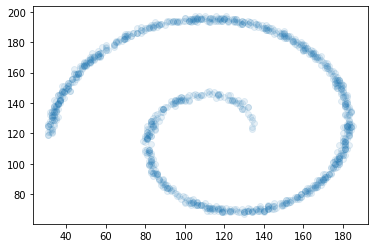

In [ ]:
# Make 8-bit swirl dataset
theta = np.sqrt(np.random.rand(N))*3*np.pi # np.linspace(0,2*pi,100)
r_a = 2*theta + np.pi
x = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
# We use 8 bits, to make this a bit similar to image data, which has 8-bit
# color channels.
x = 4*(x + .25*np.random.randn(N,2) + 30)
x = x.astype('uint8')
plt.scatter(x[:,0],x[:,1], alpha=0.1)
plt.show()

# Get mean and standard deviation of 'x'
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)

# Define model

In [ ]:
# Define learnable model
class Model(nn.Module):

  def setup(self):
    self.score_net = ScoreNetwork()
    self.noise_schedule = NoiseSchedule()

  def __call__(self, x, t):
    gamma_t = self.noise_schedule(t)
    return self.score_net(x, gamma_t)
  
  def score(self, x, t):
    return self.score_net(x, t)
  
  def gamma(self, t):
    return self.noise_schedule(t)

# A fully-connected MLP as the score network
class ScoreNetwork(nn.Module):

  def setup(self):
    self.dense1 = nn.Dense(hidden_units)
    self.dense2 = nn.Dense(hidden_units)
    self.dense3 = nn.Dense(2)
    self.ff = Base2FourierFeatures()

  def __call__(self, z, gamma_t):

    # Normalize gamma_t
    lb = init_gamma_0
    ub = init_gamma_1
    gamma_t_norm = ((gamma_t - lb) / (ub - lb))*2-1  # ---> [-1,+1]

    # Concatenate normalized gamma_t as extra feature
    h = jnp.concatenate([z, gamma_t_norm[:, None]], axis=1)

    # append Fourier features
    h_ff = self.ff(h)
    h = jnp.concatenate([h, h_ff], axis=1)

    # Three dense layers
    h = nn.swish(self.dense1(h))
    h = nn.swish(self.dense2(h))
    h = self.dense3(h)

    return h

class Base2FourierFeatures(nn.Module):
  # Create Base 2 Fourier features
  @nn.compact
  def __call__(self, inputs):
    freqs = jnp.asarray(range(8), dtype=inputs.dtype) #[0, 1, ..., 7]
    w = 2.**freqs * 2 * jnp.pi
    w = jnp.tile(w[None, :], (1, inputs.shape[-1]))
    h = jnp.repeat(inputs, len(freqs), axis=-1)
    h *= w
    h = jnp.concatenate([jnp.sin(h), jnp.cos(h)], axis=-1)
    return h

def constant_init(value, dtype='float32'):
  def _init(key, shape, dtype=dtype):
    return value * jnp.ones(shape, dtype)
  return _init

# Simple scalar noise schedule, i.e. gamma(t) in the paper:
# gamma(t) = abs(w) * t + b
class NoiseSchedule(nn.Module):

  def setup(self):
    init_bias = init_gamma_0
    init_scale = init_gamma_1 - init_gamma_0
    self.w = self.param('w', constant_init(init_scale), (1,))
    self.b = self.param('b', constant_init(init_bias), (1,))

  def __call__(self, t):
    return abs(self.w) * t + self.b

def data_encode(x):
  # This transforms x from discrete values (0, 1, ...)
  # to the domain (-1,1).
  # Rounding here just a safeguard to ensure the input is discrete
  # (although typically, x is a discrete variable such as uint8)
  x = x.round()
  return (x-x_mean)/x_std

def data_decode(z_0_rescaled, gamma_0):
  # Logits are exact if there are no dependencies between dimensions of x
  x_vals = jnp.arange(0, vocab_size)[:, None]
  x_vals = jnp.repeat(x_vals, z_0_rescaled.shape[-1], 1)
  x_vals = data_encode(x_vals).transpose([1, 0])[None, :, :]
  inv_stdev = jnp.exp(-0.5 * gamma_0[..., None])
  logits = -0.5 * jnp.square((z_0_rescaled[..., None] - x_vals) * inv_stdev)

  logprobs = jax.nn.log_softmax(logits)
  return logprobs

def data_logprob(x, z_0_rescaled, gamma_0):
  x = x.round().astype('int32')
  x_onehot = jax.nn.one_hot(x, vocab_size)
  logprobs = data_decode(z_0_rescaled, gamma_0)
  logprob = jnp.sum(x_onehot * logprobs, axis=(1, 2))
  return logprob

def data_generate_x(z_0, gamma_0, rng):
  var_0 = nn.sigmoid(gamma_0)
  z_0_rescaled = z_0 / jnp.sqrt(1. - var_0)
  logits = data_decode(z_0_rescaled, gamma_0)
  samples = jax.random.categorical(rng, logits)
  return samples

# define loss function
def loss_fn(params, x, rng):

  gamma = lambda t: model.apply(params, t, method=Model.gamma)
  gamma_0, gamma_1 = gamma(0.), gamma(1.)
  var_0, var_1 = nn.sigmoid(gamma_0), nn.sigmoid(gamma_1)
  n_batch = x.shape[0]

  # encode
  f = data_encode(x)

  # 1. RECONSTRUCTION LOSS
  # add noise and reconstruct
  rng, rng1 = jax.random.split(rng)
  eps_0 = jax.random.normal(rng1, shape=f.shape)
  z_0 = jnp.sqrt(1. - var_0) * f + jnp.sqrt(var_0) * eps_0
  z_0_rescaled = f + jnp.exp(0.5 * gamma_0) * eps_0  # = z_0/sqrt(1-var)
  loss_recon = - data_logprob(x, z_0_rescaled, gamma_0)

  # 2. LATENT LOSS
  # KL z1 with N(0,1) prior
  mean1_sqr = (1. - var_1) * jnp.square(f)
  loss_klz = 0.5 * jnp.sum(mean1_sqr + var_1 - jnp.log(var_1) - 1., axis=1)

  # 3. DIFFUSION LOSS
  # sample time steps
  rng, rng1 = jax.random.split(rng)
  t = jax.random.uniform(rng1, shape=(n_batch,))

  # discretize time steps if we're working with discrete time
  if T_train > 0:
    t = jnp.ceil(t * T_train) / T_train

  # sample z_t
  gamma_t = gamma(t)
  var_t = nn.sigmoid(gamma_t)[:, None]
  rng, rng1 = jax.random.split(rng)
  eps = jax.random.normal(rng1, shape=f.shape)
  z_t = jnp.sqrt(1. - var_t) * f + jnp.sqrt(var_t) * eps
  # compute predicted noise
  eps_hat = model.apply(params, z_t, gamma_t, method=Model.score)
  # compute MSE of predicted noise
  loss_diff_mse = jnp.sum(jnp.square(eps - eps_hat), axis=1)

  if T_train == 0:
    # loss for infinite depth T, i.e. continuous time
    _, g_t_grad = jax.jvp(gamma, (t,), (jnp.ones_like(t),))
    loss_diff = .5 * g_t_grad * loss_diff_mse
  else:
    # loss for finite depth T, i.e. discrete time
    s = t - (1./T_train)
    gamma_s = gamma(s)
    loss_diff = .5 * T_train * jnp.expm1(gamma_t - gamma_s) * loss_diff_mse

  # End of diffusion loss computation

  # Compute loss in terms of bits per dimension
  rescale_to_bpd = 1./(np.prod(x.shape[1:]) * np.log(2.))
  bpd_latent = jnp.mean(loss_klz) * rescale_to_bpd
  bpd_recon = jnp.mean(loss_recon) * rescale_to_bpd
  bpd_diff = jnp.mean(loss_diff) * rescale_to_bpd
  bpd = bpd_recon + bpd_latent + bpd_diff
  loss = bpd
  metrics = [bpd_latent, bpd_recon, bpd_diff]
  return loss, metrics

# define training step
@jax.jit
def train_step(rng, optim_state, params, x):
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  rng, rng1 = jax.random.split(rng)
  (loss, metrics), grads = grad_fn(params, x, rng1)
  updates, optim_state = optimizer.update(grads, optim_state, params)
  params = optax.apply_updates(params, updates)
  return rng, optim_state, params, loss, metrics


In [ ]:
# Initialize model
model = Model()
rng, rng1, rng2 = jax.random.split(rng, 3)
init_inputs = [128*jnp.ones((1, 2)), jnp.zeros((1,))]
params = model.init({"params": rng1, "sample": rng2}, *init_inputs)

# initialize optimizer
optimizer = optax.adamw(learning_rate)
optim_state = optimizer.init(params)

# Training loop

In [ ]:
# training loop (should take ~20 mins)
losses = []
for i in trange(num_train_steps):
  rng, optim_state, params, loss, _metrics = train_step(rng, optim_state, params, x)
  losses.append(loss)

  0%|          | 0/20000 [00:00<?, ?it/s]

# Plot results

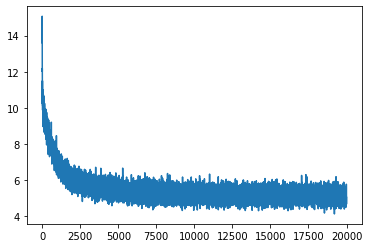

In [ ]:
plt.plot(losses)

In [ ]:
# Plot the learned endpoints of the noise schedule 
print('gamma_0', model.apply(params, 0., method=Model.gamma))
print('gamma_1', model.apply(params, 1., method=Model.gamma))

In [ ]:
# define sampling function
# t_end is integer between 0 and T_sample
def sample_fn(rng, params, N_sample, T_sample):
  # sample z_0 from the diffusion model
  rng, rng1 = jax.random.split(rng)
  z = [jax.random.normal(rng1, (N_sample, 2))]
  x_pred = []

  for i in trange(T_sample):
    rng, rng1 = jax.random.split(rng)
    _z, _x_pred = sample_step(i, T_sample, z[-1], rng1)
    z.append(_z)
    x_pred.append(_x_pred)

  gamma_0 = model.apply(params, 0., method=Model.gamma)
  x_sample = data_generate_x(z[-1], gamma_0, rng)

  return z, x_pred, x_sample

def sample_step(i, T_sample, z_t, rng):

  eps = jax.random.normal(rng, z_t.shape)

  t = (T_sample - i) / T_sample
  s = (T_sample - i - 1) / T_sample

  gamma_s = model.apply(params, s, method=Model.gamma)
  gamma_t = model.apply(params, t, method=Model.gamma)
  gamma_s *= jnp.ones((z_t.shape[0],), gamma_t.dtype)
  gamma_t *= jnp.ones((z_t.shape[0],), gamma_t.dtype)

  eps_hat = model.apply(params, z_t, gamma_t, method=Model.score)
  a = nn.sigmoid(-gamma_s)[:,None]
  b = nn.sigmoid(-gamma_t)[:,None]
  c = - jnp.expm1(gamma_s - gamma_t)[:,None]
  sigma_t = jnp.sqrt(nn.sigmoid(gamma_t))[:,None]

  z_s = jnp.sqrt(a / b) * (z_t - sigma_t * c * eps_hat) + \
      jnp.sqrt((1. - a) * c) * eps

  alpha_t = jnp.sqrt(1 - b)
  x_pred = (z_t - sigma_t * eps_hat)/alpha_t

  return z_s, x_pred


In [ ]:
# Generate samples
rng, rng1 = jax.random.split(rng)
z, x_pred, _ = sample_fn(rng1, params, N_sample=1024, T_sample=200)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Create square plot:
def plot(data, fname=None, color='blue'):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.set_aspect('equal', adjustable='box')
  ax.set_xticks([-2,0,2])
  ax.set_yticks([-2,0,2])
  plt.scatter(data[:,0], data[:,1], alpha=0.1, c=color)
  plt.xlim(-2,2)
  plt.ylim(-2,2)
  if fname != None:
    plt.savefig(fname)
    files.download(fname) 

In [ ]:
plot(z[199], 'p_0.pdf')

In [ ]:
plot(z[119], 'p_0.4.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

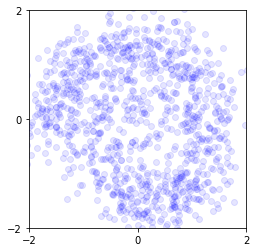

In [ ]:
plot(z[99], 'p_half.pdf')

In [ ]:
plot(z[0], 'p_1.pdf')

In [ ]:
def sample_q_t(rng, t, x):
  f = data_encode(x)
  gamma_t = model.apply(params, t, method=Model.gamma)
  var_t = nn.sigmoid(gamma_t)[:, None]
  eps = jax.random.normal(rng, shape=x.shape)
  z_t = jnp.sqrt(1. - var_t) * f + jnp.sqrt(var_t) * eps
  return z_t

In [ ]:
# Create Q plots
rng, rng1 = jax.random.split(rng)
plot(sample_q_t(rng, 0, x), 'q_0.pdf', color='red')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

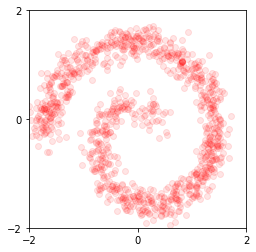

In [ ]:
rng, rng1 = jax.random.split(rng)
plot(sample_q_t(rng, .4, x), 'q_.4.pdf', color='red')

In [ ]:
rng, rng1 = jax.random.split(rng)
plot(sample_q_t(rng, .5, x), 'q_half.pdf', color='red')

In [ ]:
rng, rng1 = jax.random.split(rng)
plot(sample_q_t(rng, 1, x), 'q_1.pdf', color='red')

In [ ]:
def f_eps_hat(t, z_t):
  gamma_t = model.apply(params, t, method=Model.gamma)
  gamma_t *= jnp.ones((z_t.shape[0],), gamma_t.dtype)
  eps_hat = model.apply(params, z_t, gamma_t, method=Model.score)
  return eps_hat

# Vector field
def vector_field(t, z, fname):
  eps_hat = f_eps_hat(t, z)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.set_aspect('equal', adjustable='box')
  ax.set_xticks([-2,0,2])
  ax.set_yticks([-2,0,2])
  plt.quiver(z[:,0], z[:,1], -eps_hat[:,0], -eps_hat[:,1], width=.005)
  plt.xlim(-2,2)
  plt.ylim(-2,2)
  if fname != None:
    plt.savefig(fname)
    files.download(fname) 

vector_field(.5, z[99], 'vec_z_.5.pdf')

In [ ]:
# Create coordinate
_x = np.arange(-1.9, 1.9, 0.2)
_y = np.arange(-1.9, 1.9, 0.2)
_xs, _ys = np.meshgrid(_x, _y)
z_mesh = np.concatenate([_xs.flatten()[:,None],_ys.flatten()[:,None]], axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

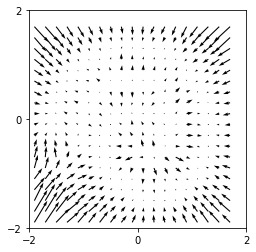

In [ ]:
vector_field(.5, z_mesh, 'vec_mesh_.5.pdf')

In [ ]:
vector_field(0.0, z_mesh, 'vec_mesh_0.pdf')

In [ ]:
vector_field(1., z_mesh, 'vec_mesh_1.pdf')

In [ ]:
vector_field(.0, z[199], 'vec_z_0.pdf')

In [ ]:
vector_field(.5, z[99], 'vec_z_.5.pdf')

In [ ]:
vector_field(1., z[0], 'vec_z_1.pdf')